# Allocate Benchmarks

In [15]:
# select measurement file
file_name = "../output/2024-05-21 16-32-14 allocate1.json"

# select style options
grey_fill_between = False

if grey_fill_between:
    fill_between_args = {"color": "grey"}
else:
    fill_between_args = {}

In [16]:
# parse data
import json

with open(file_name) as file:
    raw_data = json.load(file)

In [17]:
import pandas as pd
import numpy as np

# filter and convert data
allocate_min = filter(lambda item: item["bench_name"] == "allocate_min", raw_data)
allocate_max = filter(lambda item: item["bench_name"] == "allocate_max", raw_data)

# convert to mean + min + max data
def to_mmm_data(data):
    def convert_item(item):
        new = dict()
        new["mean"] = sum(item["data"]) / len(item["data"])
        new["min"] = min(item["data"])
        new["max"] = max(item["data"])

        for key in item["bench_options"]:
            new["options." + key] = item["bench_options"][key]
        
        for key in item:
            if key != "bench_options" and key != "data":
                new[key] = item[key]
        
        return new

    data = pd.DataFrame(list(map(convert_item, data)), columns=["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])

    # make sure machine name, cold start and repetitions match
    if len(np.unique(data["cold_start"])) > 1 or len(np.unique(data["repetitions"])) > 1 or len(np.unique(data["machine_name"])) > 1:
        raise "values should be the same"

    return data

allocate_min = to_mmm_data(allocate_min)
allocate_max = to_mmm_data(allocate_max)

In [18]:
import numpy as np

# configure gird size
grid_offset = 8

max_x = max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max())
if max_x % grid_offset != 0:
    max_x = (max_x / grid_offset) * grid_offset
    max_x += grid_offset

# set grid to be multiple of 16 (and 8)
major_ticks = np.arange(0, max_x + 1, grid_offset)
minor_ticks = np.arange(0, max_x + 1, grid_offset / 2)

Text(0.5, 1.0, 'Allocate Latency for "esp32c3"')

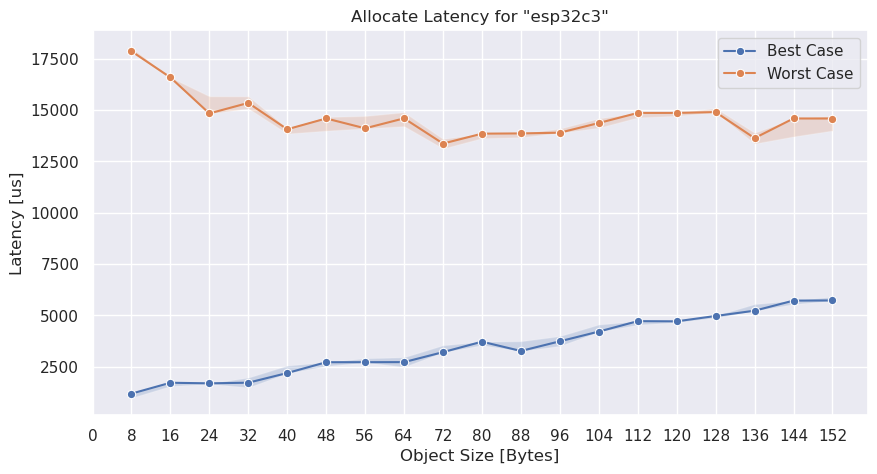

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

if len(allocate_min) != 0:
    sns.lineplot(ax=ax, data=allocate_min, x="options.object_size", y="mean", label="Best Case", markers=["o"], marker="o")
    ax.fill_between(allocate_min["options.object_size"], allocate_min["min"], allocate_min["max"], alpha=0.2, **fill_between_args)

if len(allocate_max) != 0:
    sns.lineplot(ax=ax, data=allocate_max, x="options.object_size", y="mean", label="Worst Case", markers=["o"], marker="o")
    ax.fill_between(allocate_max["options.object_size"], allocate_max["min"], allocate_max["max"], alpha=0.2, **fill_between_args)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel("Latency [us]")
ax.set_title("Allocate Latency for \"" + allocate_min["machine_name"][0] + "\"")